## Load the pre-trained word2vec model from the fake PII data. 

First, load the packages.

In [1]:
from gensim.models import Word2Vec
import pandas as pd

Load the word2vec model and the fake pii text with labels.

In [2]:
word2vec = Word2Vec.load("./word2vec/word2vec_300_fake_pii.bin")

In [3]:
fake_pii = pd.read_csv("../data/text_with_pii_2018_12_21_04_32_47_173911.csv")

# clean the text in a sentence and return a sentence.
def clean_sentence(sentence):
    
    sentence_cleaned = [word.replace(",", "").replace(".", "")\
                        .lower() for word in sentence.split(" ")]
    return " ".join(sentence_cleaned)    

context_sentences = fake_pii["Text"].apply(clean_sentence)

What the data look like?

In [4]:
fake_pii.head(10)

,Text,Labels,PII
0,Ever watch television read measure almost. Tho...,Address,Suite 971
1,Impact region card 37271 Adams Road Suite 438 ...,Address,37271 Adams Road Suite 438
2,0604 Mason Wall Throughout admit have science ...,Address,0604 Mason Wall
3,Able item bag my day impact continue. Apt. 633...,Address,Apt. 633
4,Inside perhaps Suite 744 else seven. Able seas...,Address,Suite 744
5,Feeling more reduce everything. Apt. 524 Creat...,Address,Apt. 524
6,Rule price recognize continue. Happy act agree...,Address,22471 Hannah Crossing
7,Suite 104 Some second dinner. Force past line ...,Address,Suite 104
8,"Large 930 Chad Ford Apt. 029 New Michaelmouth,...",Address,"930 Chad Ford Apt. 029 New Michaelmouth, KY 89394"
9,Future movement office. Thus building successf...,Address,"0874 Charles Forge Suite 659 Caitlinburgh, ME ..."


Take a look at the dimensions of the data.

In [5]:
fake_pii.shape

(800000, 3)

Let us take a look at one example of the data.

In [6]:
fake_pii.iloc[300001,0]

'Impact region card technology indicate. Station cut rule Patricia Smith church Congress. There west parent write. Accept image region through group matter.'

In [7]:
result_text = context_sentences[300001].split()

result_text

['impact',
 'region',
 'card',
 'technology',
 'indicate',
 'station',
 'cut',
 'rule',
 'patricia',
 'smith',
 'church',
 'congress',
 'there',
 'west',
 'parent',
 'write',
 'accept',
 'image',
 'region',
 'through',
 'group',
 'matter']

Let us see what is the most dissimilar word in the above list.

In [8]:
word2vec.wv.doesnt_match(result_text)

'patricia'

## Visualize word2vec embedding in 2d 

The next goal is to generate the embedding for the part of the PII. 

In [9]:
def find_part_pii(text, model, sep = " "):
    tokenized_text = text.split(sep)
    
    part_pii = model.wv.doesnt_match(tokenized_text)
    
    return part_pii    

In [10]:
from tqdm import tqdm
pii_list = [find_part_pii(text, model = word2vec) for text in tqdm(context_sentences) ]

100%|██████████| 800000/800000 [01:24<00:00, 9511.84it/s] 


In [11]:
import numpy as np
from tqdm import tqdm

def get_pii2vec_matrix(pii_list, model):
    # set the matrix dimensions
    column_num = model.trainables.layer1_size
    row_num = len(pii_list)
    # initialized the matrix
    pii2vec_mat = np.zeros((row_num, column_num))
    # iterate through the pii_list and assign the vectors to matrix.
    for index, ith_pii in enumerate(tqdm(pii_list)):
        pii2vec_mat[index,:] = model.wv[ith_pii]
    
    return pii2vec_mat

In [12]:
pii_matrix = get_pii2vec_matrix(pii_list = pii_list, model = word2vec)

100%|██████████| 800000/800000 [00:03<00:00, 227325.33it/s]


In [13]:
pii_labels = fake_pii["Labels"]

Visualize the resulting matrix with PCA in 2 dimensions. 

In [14]:
from yellowbrick.features.pca import PCADecomposition
import matplotlib.pyplot as plt

In [15]:
pii_labels.value_counts()

CreditCardNumber    100000
None                100000
Plates              100000
SSN                 100000
Name                100000
Phone_number        100000
Email               100000
Address             100000
Name: Labels, dtype: int64

In [16]:
color_dict = {"Phone_number":"red","SSN":"blue","Address":"black","Name":"yellow",\
             "Plates":"orange","CreditCardNumber":"purple","None":'pink',"Email":"tan"}

colors = pii_labels.map(color_dict)

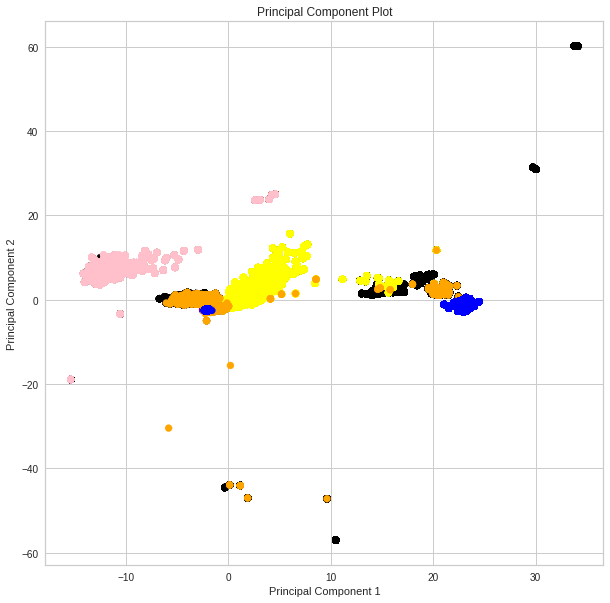

In [17]:
plt.figure(figsize=(10,10))
PCAvisualizer = PCADecomposition(scale=True, color = colors, proj_dim = 2)
PCAvisualizer.fit_transform(pii_matrix, pii_labels)
PCAvisualizer.poof()

The color and PII type are related as 
{"Phone_number":"red","SSN":"blue","Address":"black","Name":"yellow",\
             "Plates":"orange","CreditCardNumber":"purple","None":'pink',"Email":"tan"}

### The Pink is the non-PII data and others are different types of PII. A Logistic regression can have a good performance on seprating the PII vs non-PII data.

## Try a logistic regression classifier for performance. 

Train a Logistic regression to classify different PIIs and non-PII text. 

In [18]:
fake_pii["Extracted_PII"] = pii_list

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_multi = LogisticRegression(random_state=0, multi_class='multinomial',solver='lbfgs',max_iter=10000)

lr_multi.fit(pii_matrix, fake_pii["Labels"])


In [ ]:
prediction = lr_multi.predict(pii_matrix)

In [ ]:
def binary_pii(label):
    pii_label = "No"
    if label != "None":
        pii_label = "Yes"
    return pii_label 
        
binary_true = [binary_pii(label) for label in fake_pii["Labels"]]

binary_pred = [binary_pii(label) for label in prediction]

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
binary_true = pd.Series(binary_true)
binary_true.value_counts()

In [ ]:
binary_pred = pd.Series(binary_pred)
binary_pred.value_counts()

In [ ]:
from sklearn.metrics import classification_report

## The non-PII vs PII binary classification result. 

In [ ]:
%%time
print(classification_report(y_true = binary_true, y_pred = binary_pred))

##  The multi-class PII classification result.

In [ ]:
%%time
print(classification_report(y_true = fake_pii["Labels"], y_pred = prediction))

The model achieves a pretty good performance on binary classification of text with/without PII as expected from the PCA visualizer. A much better model can be trained to deal with better performance among recognizing different PII types. 

### But a more important problem to solve was how to generalize the trained model to perform on unseen data if  the model has not seen this specific PII data before. 